In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import scipy.stats as scs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone

from sklearn.datasets import load_boston

/Users/mickey/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
#reading the data
raw = pd.read_stata('integrated_dataset.dta', convert_categoricals = 0)
raw['country'].head()

0    40
1    40
2    40
3    40
4    40
Name: country, dtype: int16

In [55]:
#main data shaping
countries = [40,250,276,380,756]
raw = pd.DataFrame(raw.loc[raw.country.isin(countries)])
df = pd.DataFrame(raw[['id_cocas','country','v243_r','v262_r','v263_r','v246_ISCO_2',
                      'v228b_r','v276_r','v226','v239_r','v8','v261','v156','v6','v85',
                      'v86','v87','v88','v89','v90','v91','v92','v93','v94','v95','v31',
                      'v102','v51','v52','v54','v56','v64','v225','pweight']]).copy()

#education resp v243_r, father v262_r, mother v263_r
df['education_num'] = np.where(df['v243_r'] < 1, float('NaN'), 
                              np.where(df['v243_r'] == 66, float('NaN'),df['v243_r']))
df['education'] = np.where(df['education_num'] == 1, 'a. edu|lower',
                               np.where(df['education_num'] == 2, 'b. edu|medium',
                                        np.where(df['education_num'] == 3, 'c. edu|higher', np.nan)))
df["respondent's education"] = np.where(df['education_num'] == 1, 'a. lower',
                               np.where(df['education_num'] == 2, 'b. medium',
                                        np.where(df['education_num'] == 3, 'c. higher', np.nan)))

#sex resondent v225
df['gender_num'] = np.where(df['v225'] < 1, float('NaN'), df['v225'])
df['gender'] = np.where(df['v225'] == 1, 'male',
                               np.where(df['v225'] == 2, 'female',
                                       np.NaN))

#health professional v246_ISCO_2
df['health_professional_num'] = np.where(df['v246_ISCO_2'] == 22, 1, 0)
df['health_professional'] = np.where(df['v246_ISCO_2'] == 22, 'health professional', 'other')
 
#age v226
df['age_num'] = np.where(df['v226'] < 0, float('NaN'),2018 - df['v226'])
df['age'] = np.where(np.isnan(df['age_num']), float('NaN'),
                        np.where(np.logical_and(df['age_num']>=18, df['age_num']<=24),'a. age|18-24',
                                 np.where(np.logical_and(df['age_num']>=25, df['age_num']<=49),'b. age|25-49',
                                          np.where(np.logical_and(df['age_num']>=50, df['age_num']<=65),'c. age|50-65',
                                                   np.where(df['age_num']> 65,'d. age|+65','wrong')))))

df['age '] = np.where(np.isnan(df['age_num']), float('NaN'),
                        np.where(np.logical_and(df['age_num']>=18, df['age_num']<=24),'a. 18-24',
                                 np.where(np.logical_and(df['age_num']>=25, df['age_num']<=49),'b. 25-49',
                                          np.where(np.logical_and(df['age_num']>=50, df['age_num']<=65),'c. 50-65',
                                                   np.where(df['age_num']> 65,'d. +65','wrong')))))

df['age_num'] = np.where(np.isnan(df['age_num']), np.nan,
                        np.where(np.logical_and(df['age_num']>=18, df['age_num']<=24),1,
                                 np.where(np.logical_and(df['age_num']>=25, df['age_num']<=49),2,
                                          np.where(np.logical_and(df['age_num']>=50, df['age_num']<=65),3,4))))

#country
df['country'] = np.where(df['country'] == 40,'Austria',
                        np.where(df['country'] == 250,'France',
                                np.where(df['country'] == 276,'Germany',
                                         np.where(df['country'] == 380,'Italy',
                                            np.where(df['country'] == 756,'Switzerland',float('NaN'))))))

#urban and rural v276_r 0=rural 1=urban
df['urban_num'] = np.where(df['v276_r'] <= 2,0,1)
df['urban'] = np.where(df['urban_num'] == 1, 'urban',
                               np.where(df['urban_num'] == 0, 'rural',
                                       np.NaN))

#kids v239_r 0=0 1=yes
df['children_num'] = np.where(df['v239_r'] < 0, float('NaN'),
                        np.where(df['v239_r'] == 0,0,
                                 np.where(df['v239_r'] > 0,1,float('NaN'))))
df['children'] = np.where(df['children_num'] == 1, 'one or more',
                               np.where(df['children_num'] == 0, 'no children',
                                       np.NaN))


#state of healht v8 (1-very good, 5-very poor)
df['state_of_health_num'] = np.where(df['v8'] < 0, float('NaN'), df['v8'])
df['state_of_health'] = np.where(df['state_of_health_num'] == 1, 'a. health|very good',
                               np.where(df['state_of_health_num'] == 2, 'b. health|good',
                                        np.where(df['state_of_health_num'] == 3, 'c. health|fair',
                                                 np.where(df['state_of_health_num'] == 4, 'e. health|poor',
                                                          np.where(df['state_of_health_num'] == 5, 'f. health|very poor',
                                                                   np.NaN)))))

#houshold net income v261 (1-1st decile, 10-10th decile)
df['income_num'] = np.where(df['v261'] < 0, float('NaN'), df['v261'])
df['income_num'] = np.where(np.isnan(df['income_num']),round(df.groupby(['country','urban','age','education'])['income_num'].transform(lambda x: x.fillna(x.quantile(.5))),0),df['income_num'])
df['income'] = np.where(df['income_num'] < 0, float('NaN'),
                        np.where(np.logical_and(df['income_num']>=1, df['income_num']<=3),'a. income|buttom 30%',
                                 np.where(np.logical_and(df['income_num']>=4, df['income_num']<=7),'b. income|mid 40%',
                                          np.where(df['income_num']>=8,'c. income|top 30%','wrong'))))
df['income_num'] = np.where(df['income_num'] < 0, np.nan,
                        np.where(np.logical_and(df['income_num']>=1, df['income_num']<=3),1,
                                 np.where(np.logical_and(df['income_num']>=4, df['income_num']<=7),2,3)))


#target variable justify euthanasia v156 (1-never, 10-always)
df['justify_euthanasia_num'] = np.where(df['v156'] < 0, np.nan, df['v156'])
df['justify_euthanasia'] = np.where(df['justify_euthanasia_num'] <= 5,'not in favor',
                                      np.where(df['justify_euthanasia_num'] >= 6,'in favor','undecided'))
df['justify_euthanasia_num'] = np.where(df['justify_euthanasia_num'] <= 5,0,
                                      np.where(df['justify_euthanasia_num'] >= 6,1,np.nan))

#religion
##how important in your live: religion v6 (1 very important, 2 quite important,3 not important,4 not at all important)
df['importance_of_religion_num'] = np.where(df['v6'] < 0, float('NaN'), df['v6'])
df['importance_of_religion_num'] = np.where(pd.isna(df['importance_of_religion_num']),round(df.groupby(['country','urban','age','education'])['importance_of_religion_num'].transform(lambda x: x.fillna(x.quantile(.5))),0),df['importance_of_religion_num'])
df['importance_of_religion'] = np.where(df['importance_of_religion_num'] == 1,'a. relImportance|very important',
                                      np.where(df['importance_of_religion_num'] == 2,'b. relImportance|quite important',
                                              np.where(df['importance_of_religion_num'] == 3,'c. relImportance|not important',
                                                       np.where(df['importance_of_religion_num'] == 4,'d. relImportance|not at all important', 'Unknown'))))
df['importance of religion'] = np.where(df['importance_of_religion_num'] == 1,'very important',
                                      np.where(df['importance_of_religion_num'] == 2,'quite important',
                                              np.where(df['importance_of_religion_num'] == 3,'not important',
                                                       np.where(df['importance_of_religion_num'] == 4,'not at all important', 'Unknown'))))
##do you belong to a religious denomination (1yes, 2no)
df['rel_denomination_binary_num'] = np.where(df['v51'] < 0, float('NaN'), df['v51'])
##harmonized religious denomination
df['rel_denomination'] = np.where(df['v52'] == 1, 'Roman catholic',
                                    np.where(df['v52'] == 2, 'Protestant',
                                                np.where(df['v52'] == 3, 'Other Christians',
                                                        np.where(df['v52'] == 4, 'Other',
                                                                    np.where(df['v52'] == 5, 'Muslim',
                                                                                np.where(df['v52'] == 6, 'Other Rel. Denomination',
                                                                                        np.where(df['v52'] == 7, 'Other',
                                                                                                np.where(df['v52'] == 8, 'Other Christians',
                                                                                                         np.where(df['rel_denomination_binary_num'] == 2,'No Rel. Denomination',
                                                                                                                  np.where(df['v52'] == 9, 'Other', 'Unknown'))))))))))
df['religious denomination'] = np.where(df['v52'] == 1, 'Roman catholic',
                                    np.where(df['v52'] == 2, 'Protestant',
                                                np.where(df['v52'] == 3, 'Other Christians',
                                                        np.where(df['v52'] == 4, 'Other',
                                                                    np.where(df['v52'] == 5, 'Muslim',
                                                                                np.where(df['v52'] == 6, 'Other',
                                                                                        np.where(df['v52'] == 7, 'Other',
                                                                                                np.where(df['v52'] == 8, 'Other Christians',
                                                                                                         np.where(df['rel_denomination_binary_num'] == 2,'None',
                                                                                                                  np.where(df['v52'] == 9, 'Other', 'Unknown'))))))))))

df['rel_denomination_binary_num'] = np.where(df['rel_denomination'] != 'No Rel. Denomination',1,
                                             np.where(df['rel_denomination'] == 'No Rel. Denomination',2, np.NaN))
df['rel_denomination_binary'] = np.where(df['rel_denomination_binary_num'] == 2, 'no',
                                             np.where(df['rel_denomination_binary_num'] == 1, 'yes', np.NaN))

df['belongs to a religious denomination'] = np.where(df['rel_denomination_binary_num'] == 2, 'no',
                                             np.where(df['rel_denomination_binary_num'] == 1, 'yes', np.NaN))
##how often attend religious services v54
                                                                                                         
###1 more than once a week, 2 once a week, 3 once a month,
###4 only on specific holy days, 5 once a year, 6 less often, 7 practically never                                                                                                   
df['rel_attend_rel_services_num'] = np.where(df['v54'] < 0, float('NaN'), df['v54'])
df['rel_attend_rel_services_num'] = np.where(np.isnan(df['rel_attend_rel_services_num']),round(df.groupby(['country','urban','age','education'])['rel_attend_rel_services_num'].transform(lambda x: x.fillna(x.quantile(.5))),0),df['rel_attend_rel_services_num'])
df['rel_attend_rel_services'] = np.where(df['rel_attend_rel_services_num'] == 1, 'a. relService|more than once a week',
                                               np.where(df['rel_attend_rel_services_num'] == 2,'b. relService|once a week',
                                                        np.where(df['rel_attend_rel_services_num'] == 3,'c. relService|once a month',
                                                                 np.where(df['rel_attend_rel_services_num'] == 4,'d. relService|only on specific holy days',
                                                                          np.where(df['rel_attend_rel_services_num'] == 5,'e. relService|once a year',
                                                                                   np.where(df['rel_attend_rel_services_num'] == 6,'f. relService|less often',
                                                                                            np.where(df['rel_attend_rel_services_num'] == 7,'g. relService|practically never','unkown')))))))
###1 a religious person,2 not a relgious person,3 a convinced atheist
df['religious_person_num'] = np.where(df['v56'] < 0, float('NaN'), df['v56'])
df['religious_person_num'] = np.where(np.isnan(df['religious_person_num']),round(df.groupby(['country','urban','age','education'])['religious_person_num'].transform(lambda x: x.fillna(x.quantile(.5))),0),df['religious_person_num'])
df['religious_person'] = np.where(df['religious_person_num'] == 1,'a. relPerson|yes',
                                  np.where(df['religious_person_num'] == 2,'b. relPerson|no',
                                           np.where(df['religious_person_num'] == 3,'c. relPerson|atheist',np.NaN)))
df['religious person'] = np.where(df['religious_person_num'] == 1,'yes',
                                  np.where(df['religious_person_num'] == 2,'no',
                                           np.where(df['religious_person_num'] == 3,'atheist',np.NaN)))

##how often do you pray outside of religious services v64
### 1 every day,2 more than once week,3 at least once a week,4 at least once a month
### 5 several times a year,6 less often,7 never
df['rel_pray_oustide_rel_services_num'] = np.where(df['v64'] < 0, float('NaN'), df['v64'])
df['rel_pray_oustide_rel_services_num'] = np.where(np.isnan(df['rel_pray_oustide_rel_services_num']),round(df.groupby(['country','urban','age','education'])['rel_pray_oustide_rel_services_num'].transform(lambda x: x.fillna(x.quantile(.5))),0),df['rel_pray_oustide_rel_services_num'])
df['rel_pray_oustide_rel_services'] = np.where(df['rel_pray_oustide_rel_services_num'] == 1, 'a. pray|every day',
                                               np.where(df['rel_pray_oustide_rel_services_num'] == 2,'b. pray|more than once a week',
                                                        np.where(df['rel_pray_oustide_rel_services_num'] == 3,'c. pray|at least once a week',
                                                                 np.where(df['rel_pray_oustide_rel_services_num'] == 4,'d. pray|at least once a month',
                                                                          np.where(df['rel_pray_oustide_rel_services_num'] == 5,'e. pray|several times a year',
                                                                                   np.where(df['rel_pray_oustide_rel_services_num'] == 6,'f. pray|less often',
                                                                                            np.where(df['rel_pray_oustide_rel_services_num'] == 7,'g. pray|never','unkown')))))))


#conservative vs progressiv 1 mentioned 2 not mentioned
df['value_manners_num'] = np.where(df['v85'] < 0, float('NaN'), df['v85'])
df['value_manners_num'] = np.where(np.isnan(df['value_manners_num']),round(df.groupby(['country','urban','age','education'])['value_manners_num'].transform(lambda x: x.fillna(x.quantile(.5))),0),df['value_manners_num'])
df['value_manners'] = np.where(df['value_manners_num'] == 1, 'mentioned', 'not_mentioned')

df['value_independence_num'] = np.where(df['v86'] < 0, float('NaN'), df['v86'])
df['value_independence_num'] = np.where(np.isnan(df['value_independence_num']),round(df.groupby(['country','urban','age','education'])['value_independence_num'].transform(lambda x: x.fillna(x.quantile(.5))),0),df['value_independence_num'])
df['value_independence'] = np.where(df['value_independence_num'] == 1, 'mentioned', 'not_mentioned')

df['value_hardwork_num'] = np.where(df['v87'] < 0, float('NaN'), df['v87'])
df['value_hardwork_num'] = np.where(np.isnan(df['value_hardwork_num']),round(df.groupby(['country','urban','age','education'])['value_hardwork_num'].transform(lambda x: x.fillna(x.quantile(.5))),0),df['value_hardwork_num'])
df['value_hardwork'] = np.where(df['value_hardwork_num'] == 1, 'mentioned', 'not_mentioned')

df['value_responsibility_num'] = np.where(df['v88'] < 0, float('NaN'), df['v88'])
df['value_responsibility_num'] = np.where(np.isnan(df['value_responsibility_num']),round(df.groupby(['country','urban','age','education'])['value_responsibility_num'].transform(lambda x: x.fillna(x.quantile(.5))),0),df['value_responsibility_num'])
df['value_responsibility'] = np.where(df['value_responsibility_num'] == 1, 'mentioned', 'not_mentioned')

df['value_imagination_num'] = np.where(df['v89'] < 0, float('NaN'), df['v89'])
df['value_imagination_num'] = np.where(np.isnan(df['value_imagination_num']),round(df.groupby(['country','urban','age','education'])['value_imagination_num'].transform(lambda x: x.fillna(x.quantile(.5))),0),df['value_imagination_num'])
df['value_imagination'] = np.where(df['value_imagination_num'] == 1, 'mentioned', 'not_mentioned')

df['value_tolerancerespect_num'] = np.where(df['v90'] < 0, float('NaN'), df['v90'])
df['value_tolerancerespect_num'] = np.where(np.isnan(df['value_tolerancerespect_num']),round(df.groupby(['country','urban','age','education'])['value_tolerancerespect_num'].transform(lambda x: x.fillna(x.quantile(.5))),0),df['value_tolerancerespect_num'])
df['value_tolerancerespect'] = np.where(df['value_tolerancerespect_num'] == 1, 'mentioned', 'not_mentioned')

df['value_thriftsaving_num'] = np.where(df['v91'] < 0, float('NaN'), df['v91'])
df['value_thriftsaving_num'] = np.where(np.isnan(df['value_thriftsaving_num']),round(df.groupby(['country','urban','age','education'])['value_thriftsaving_num'].transform(lambda x: x.fillna(x.quantile(.5))),0),df['value_thriftsaving_num'])
df['value_thriftsaving'] = np.where(df['value_thriftsaving_num'] == 1, 'mentioned', 'not_mentioned')

df['value_determinationperseverance_num'] = np.where(df['v92'] < 0, float('NaN'), df['v92'])
df['value_determinationperseverance_num'] = np.where(np.isnan(df['value_determinationperseverance_num']),round(df.groupby(['country','urban','age','education'])['value_determinationperseverance_num'].transform(lambda x: x.fillna(x.quantile(.5))),0),df['value_determinationperseverance_num'])
df['value_determinationperseverance'] = np.where(df['value_determinationperseverance_num'] == 1, 'mentioned', 'not_mentioned')

df['value_religionsfaith_num'] = np.where(df['v93'] < 0, float('NaN'), df['v93'])
df['value_religionsfaith_num'] = np.where(np.isnan(df['value_religionsfaith_num']),round(df.groupby(['country','urban','age','education'])['value_religionsfaith_num'].transform(lambda x: x.fillna(x.quantile(.5))),0),df['value_religionsfaith_num'])
df['value_religionsfaith'] = np.where(df['value_religionsfaith_num'] == 1, 'mentioned', 'not_mentioned')

df['value_unselfishness_num'] = np.where(df['v94'] < 0, float('NaN'), df['v94'])
df['value_unselfishness_num'] = np.where(np.isnan(df['value_unselfishness_num']),round(df.groupby(['country','urban','age','education'])['value_unselfishness_num'].transform(lambda x: x.fillna(x.quantile(.5))),0),df['value_unselfishness_num'])
df['value_unselfishness'] = np.where(df['value_unselfishness_num'] == 1, 'mentioned', 'not_mentioned')

df['value_obedience_num'] = np.where(df['v95'] < 0, float('NaN'), df['v95'])
df['value_obedience_num'] = np.where(np.isnan(df['value_obedience_num']),round(df.groupby(['country','urban','age','education'])['value_obedience_num'].transform(lambda x: x.fillna(x.quantile(.5))),0),df['value_obedience_num'])
df['value_obedience'] = np.where(df['value_obedience_num'] == 1, 'mentioned', 'not_mentioned')


df['trust_num'] = np.where(df['v31'] < 0, np.NaN, df['v31'])
df['trust_num'] = np.where(np.isnan(df['trust_num']),round(df.groupby(['country','urban','age','education'])['trust_num'].transform(lambda x: x.fillna(x.quantile(.5))),0),df['trust_num'])
df['trust'] = np.where(df['trust_num'] == 1, 'most people can be trusted',np.where(df['trust_num'] == 2, 'can not be too careful', np.NaN))
#political view v102 (1 very left, 10 very right)
df['leftVSright_num'] = np.where(df['v102'] < 0, np.NaN, df['v102'])
df['leftVSright_num'] = np.where(np.isnan(df['leftVSright_num']),round(df.groupby(['country','urban','age','education'])['leftVSright_num'].transform(lambda x: x.fillna(x.quantile(.5))),0),df['leftVSright_num'])
df['leftVSright'] = np.where(df['leftVSright_num'] <= 2, 'a. far left',
                             np.where(df['leftVSright_num'].between(3, 5), 'b. left',
                                      np.where(df['leftVSright_num'].between(6, 8), 'c. right','d. far right')))
df['leftVSright_num'] = np.where(df['leftVSright_num'] <= 2, 1,
                             np.where(df['leftVSright_num'].between(3, 5), 2,
                                      np.where(df['leftVSright_num'].between(6, 8), 3,4)))


In [56]:
#create the working df with relevant variables only
df_working = pd.DataFrame(df[['id_cocas', 'country',
       'pweight', 'education_num', 'education', 'gender_num', 'gender',
       'health_professional_num', 'health_professional', 'age_num', 'age', 'age ',
       'urban_num', 'urban', 'children_num', 'children', 'state_of_health_num',
       'state_of_health', 'income_num', 'income', 'justify_euthanasia_num',
       'justify_euthanasia', 'importance_of_religion_num',
       'importance_of_religion', 'rel_denomination_binary_num',
       'rel_denomination', 'rel_denomination_binary',
       'rel_attend_rel_services_num', 'rel_attend_rel_services',
       'religious_person_num', 'religious_person',
       'rel_pray_oustide_rel_services_num', 'rel_pray_oustide_rel_services',
       'value_manners_num', 'value_manners', 'value_independence_num',
       'value_independence', 'value_hardwork_num', 'value_hardwork',
       'value_responsibility_num', 'value_responsibility',
       'value_imagination_num', 'value_imagination',
       'value_tolerancerespect_num', 'value_tolerancerespect',
       'value_thriftsaving_num', 'value_thriftsaving',
       'value_determinationperseverance_num',
       'value_determinationperseverance', 'value_religionsfaith_num',
       'value_religionsfaith', 'value_unselfishness_num',"respondent's education",
       'value_unselfishness', 'value_obedience_num', 'value_obedience',
       'trust_num', 'trust', 'leftVSright_num', 'leftVSright','belongs to a religious denomination','religious denomination','religious person','importance of religion']]).reset_index(drop=1)


df_working.isnull().sum()
before = len(df_working)
df_working = df_working.dropna().reset_index(drop=1)
after = len(df_working)
print('before: ',before,' after:', after, ' diff:', before - after)

#df_working[df_working.income == 'nan'][['income_num','income']]

before:  14858  after: 12113  diff: 2745


Text(0.5, 0.98, 'Attitude towards Euthanasia by selected socio demographic variables (Frequencies)')

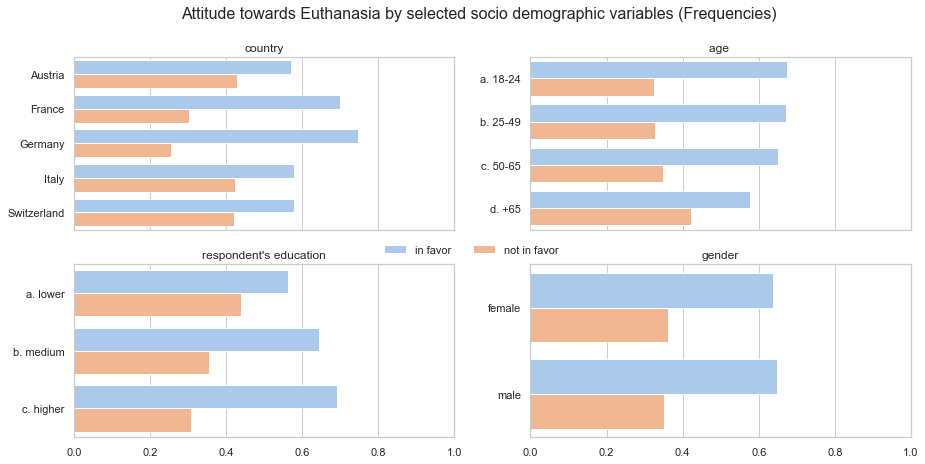

In [57]:
#bivariate analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 7),sharex=True)

sns.set(style="whitegrid")
d = df_working

d['frequency'] = 0 # a dummy column to refer to
for col, ax in zip(['country', 'age ',"respondent's education",'gender'], axes.flatten()):
    counts = d.groupby([col, 'justify_euthanasia']).count()
    freq_per_group = counts.div(counts.groupby(col).transform('sum')).reset_index()
    sns.barplot(y=col, x='frequency', hue='justify_euthanasia', data=freq_per_group, ax=ax, palette="pastel", hue_order = ['in favor', 'not in favor'],errwidth=.5)
    #ax.legend(handles, labels, loc='lower right', ncol=3, bbox_to_anchor=(1.25,1))
    ax.set(title = col, xlabel='', ylabel='')
    ax.legend_.remove()
    ax.set_xlim(0, 1)
ax.legend(ncol=3, bbox_to_anchor=(0.10, 1.17),frameon=False)

fig.suptitle('Attitude towards Euthanasia by selected socio demographic variables (Frequencies)', fontsize=16)
    

Text(0.5, 0.98, 'Attitude towards Euthanasia by socio demographic variables showing bivariate effects')

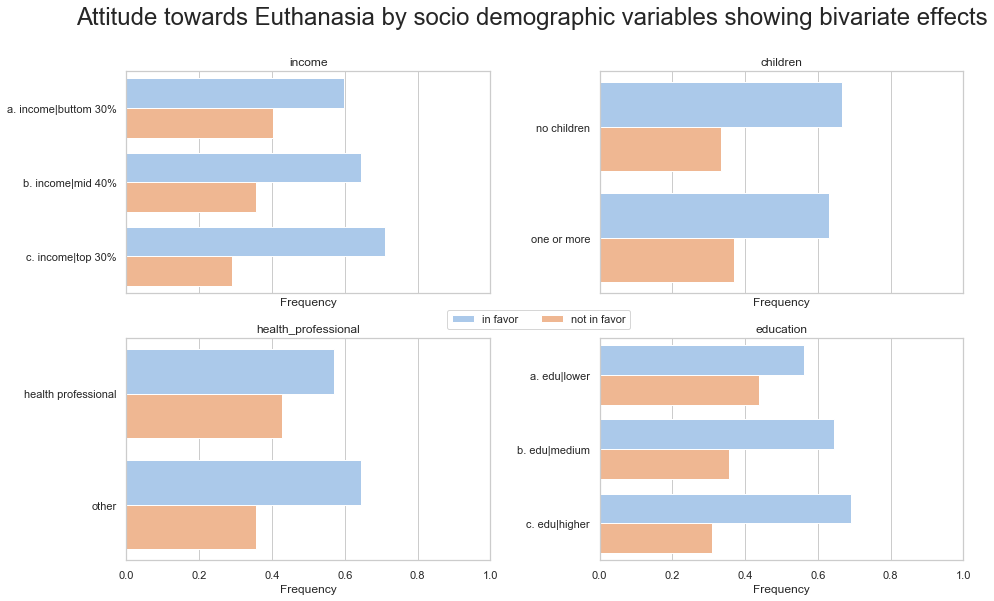

In [53]:
#bivariate analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 9),sharex=True)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)

sns.set(style="whitegrid")
d = df_working

d['frequency'] = 0 # a dummy column to refer to
for col, ax in zip(['income', 'children','health_professional','education'], axes.flatten()):
    counts = d.groupby([col, 'justify_euthanasia']).count()
    freq_per_group = counts.div(counts.groupby(col).transform('sum')).reset_index()
    sns.barplot(y=col, x='frequency', hue='justify_euthanasia', data=freq_per_group, ax=ax, palette="pastel", hue_order =['in favor', 'not in favor'],errwidth=.5)
    #ax.legend(handles, labels, loc='lower right', ncol=3, bbox_to_anchor=(1.25,1))
    ax.set(title = col, xlabel='Frequency', ylabel='')
    ax.legend_.remove()
    ax.set_xlim(0, 1)
ax.legend(ncol=3, bbox_to_anchor=(0.10, 1.17),frameon=False)

fig.suptitle('Attitude towards Euthanasia by socio demographic variables showing bivariate effects', fontsize=24)

Text(0.5, 0.98, "Attitude towards Euthanasia by variables related to a person's religious believe (Frequencies)")

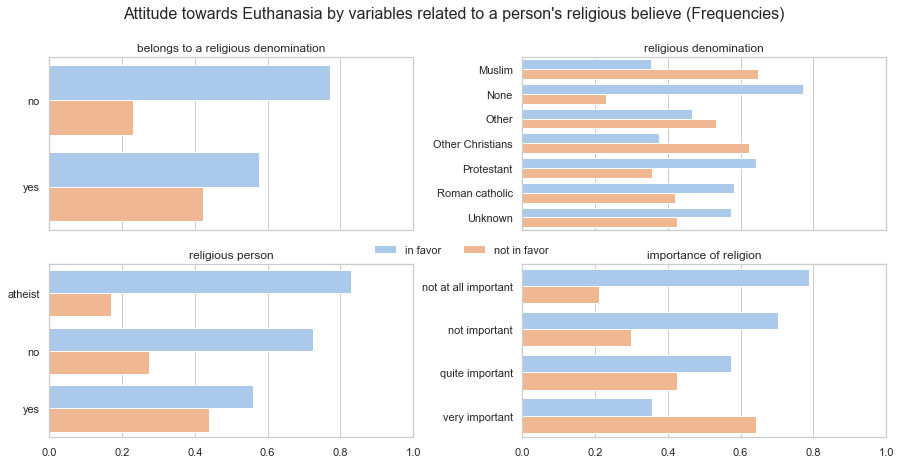

In [59]:
#bivariate analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 7),sharex=True)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)

sns.set(style="whitegrid")
d = df_working

d['frequency'] = 0 # a dummy column to refer to
for col, ax in zip(['belongs to a religious denomination','religious denomination','religious person','importance of religion'], axes.flatten()):
    counts = d.groupby([col, 'justify_euthanasia']).count()
    freq_per_group = counts.div(counts.groupby(col).transform('sum')).reset_index()
    sns.barplot(y=col, x='frequency', hue='justify_euthanasia', data=freq_per_group, ax=ax, palette="pastel", hue_order = ['in favor', 'not in favor'],errwidth=.5)
    #ax.legend(handles, labels, loc='lower right', ncol=3, bbox_to_anchor=(1.25,1))
    ax.set(title = col, xlabel='', ylabel='')
    ax.legend_.remove()
    ax.set_xlim(0, 1)
ax.legend(ncol=3, bbox_to_anchor=(0.10, 1.17),frameon=False)

fig.suptitle("Attitude towards Euthanasia by variables related to a person's religious believe (Frequencies)", fontsize=16)

Text(0.5, 0.98, 'Attitude towards Euthanasia by emphasized values I')

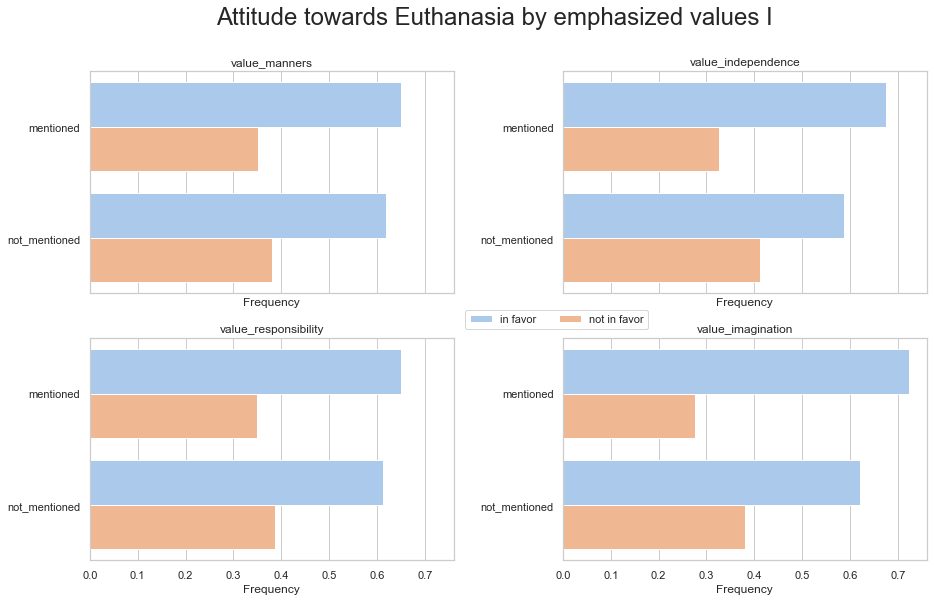

In [104]:
#bivariate analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 9),sharex=True)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)

sns.set(style="whitegrid")
d = df_working

d['frequency'] = 0 # a dummy column to refer to
for col, ax in zip(['value_manners', 'value_independence','value_responsibility','value_imagination'], axes.flatten()):
    counts = d.groupby([col, 'justify_euthanasia']).count()
    freq_per_group = counts.div(counts.groupby(col).transform('sum')).reset_index()
    sns.barplot(y=col, x='frequency', hue='justify_euthanasia', data=freq_per_group, ax=ax, palette="pastel", hue_order = ['in favor', 'not in favor'],errwidth=.5)
    #ax.legend(handles, labels, loc='lower right', ncol=3, bbox_to_anchor=(1.25,1))
    ax.set(title = col, xlabel='Frequency', ylabel='')
    ax.set_xlim(0, 1)
ax.legend(ncol=3, bbox_to_anchor=(0.10, 1.17),frameon=False)

fig.suptitle('Attitude towards Euthanasia by emphasized values I', fontsize=24)

In [16]:
# chi square
import pandas
from scipy.stats import chi2_contingency

def chisq_of_df_cols(df, c1, c2):
    groupsizes = df.groupby([c1, c2]).size()
    ctsum = groupsizes.unstack(c1)
    # fillna(0) is necessary to remove any NAs which will cause exceptions
    return(chi2_contingency(ctsum.fillna(0)))

chisq_of_df_cols(df_working, 'rel_denomination_binary_num', 'justify_euthanasia_num')

(445.5603057376922,
 6.673081674786758e-99,
 1,
 array([[1482.8469413, 2842.1530587],
        [2670.1530587, 5117.8469413]]))

Text(0.5, 0.98, 'Attitude towards Euthanasia by political view, trust and personal values (Frequencies)')

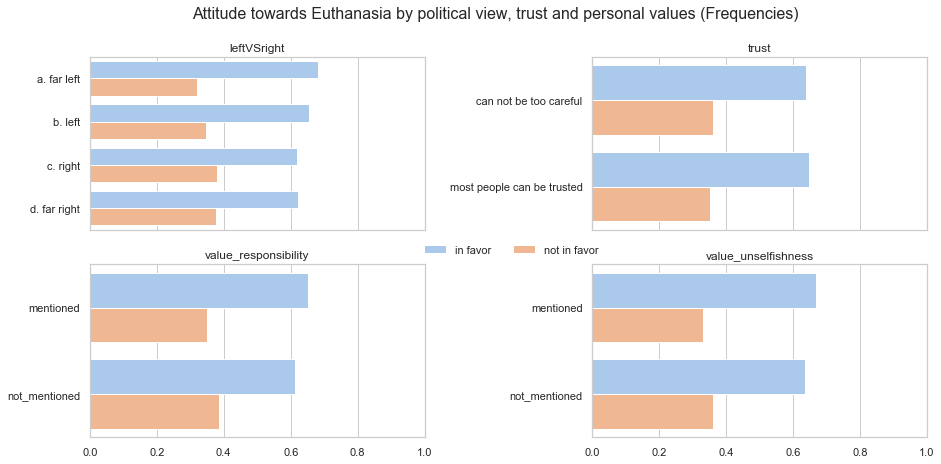

In [62]:
#bivariate analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 7),sharex=True)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

sns.set(style="whitegrid")
d = df_working

d['frequency'] = 0 # a dummy column to refer to
for col, ax in zip(['leftVSright','trust',  'value_responsibility','value_unselfishness'], axes.flatten()):
    counts = d.groupby([col, 'justify_euthanasia']).count()
    freq_per_group = counts.div(counts.groupby(col).transform('sum')).reset_index()
    sns.barplot(y=col, x='frequency', hue='justify_euthanasia', data=freq_per_group, ax=ax, palette="pastel", hue_order = ['in favor', 'not in favor'],errwidth=.5)
    #ax.legend(handles, labels, loc='lower right', ncol=3, bbox_to_anchor=(1.25,1))
    ax.set(title = col, xlabel='', ylabel='')
    ax.legend_.remove()
    ax.set_xlim(0, 1)
ax.legend(ncol=3, bbox_to_anchor=(0.05, 1.17),frameon=False)

fig.suptitle('Attitude towards Euthanasia by political view, trust and personal values (Frequencies)', fontsize=16)

In [202]:
#one hot encoding
onehot_rel_denomination = pd.get_dummies(df_working['rel_denomination'])
onehot_country = pd.get_dummies(df_working['country'])
onehot_education = pd.get_dummies(df_working['education'])
onehot_age = pd.get_dummies(df_working['age'])
onehot_state_of_health = pd.get_dummies(df_working['state_of_health'])
onehot_income = pd.get_dummies(df_working['income'])
onehot_importance_of_religion = pd.get_dummies(df_working['importance_of_religion'])
onehot_rel_attend_rel_services = pd.get_dummies(df_working['rel_attend_rel_services'])
onehot_religious_person = pd.get_dummies(df_working['religious_person'])
onehot_rel_pray_oustide_rel_services = pd.get_dummies(df_working['rel_pray_oustide_rel_services'])
onehot_leftVSright = pd.get_dummies(df_working['leftVSright'])

df_pred = pd.concat([df_working, onehot_rel_denomination, onehot_country, onehot_education, onehot_age, onehot_state_of_health, onehot_income,onehot_importance_of_religion,onehot_rel_attend_rel_services,onehot_religious_person,onehot_rel_pray_oustide_rel_services,onehot_leftVSright],
                               axis=1)
pd.set_option('display.max_rows', 500)


id_cocas                                    0
country                                     0
pweight                                     0
education_num                               0
education                                   0
gender_num                                  0
gender                                      0
health_professional_num                     0
health_professional                         0
age_num                                     0
age                                         0
urban_num                                   0
urban                                       0
children_num                                0
children                                    0
state_of_health_num                         0
state_of_health                             0
income_num                                  0
income                                      0
justify_euthanasia_num                      0
justify_euthanasia                          0
importance_of_religion_num        

In [203]:
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression

In [190]:
#data_final = df_pred[['gender_num','health_professional_num','urban_num','children_num','state_of_health_num','income_num','justify_euthanasia_num','rel_attend_rel_services_num','religious_person_num','rel_pray_oustide_rel_services_num','value_manners_num','value_independence_num','value_hardwork_num','value_responsibility_num','value_imagination_num','value_tolerancerespect_num','value_thriftsaving_num','value_determinationperseverance_num','value_religionsfaith_num','value_unselfishness_num','value_obedience_num','trust_num','leftVSright_num','Muslim','None','Other','Other Christians','Protestant','Roman catholic','Unknown','Austria','France','Germany','Italy','Switzerland','a. edu|lower','b. edu|medium','c. edu|higher','a. age|18-24','b. age|25-49','c. age|50-65','d. age|+65','a. health|very good','b. health|good','c. health|fair','e. health|poor','f. health|very poor','a. income|buttom 30%','b. income|mid 40%','c. income|top 30%','a. relImportance|very important','b. relImportance|quite important','c. relImportance|not important','d. relImportance|not at all important','a. relService|more than once a week','b. relService|once a week','c. relService|once a month','d. relService|only on specific holy days','e. relService|once a year','f. relService|less often','g. relService|practically never','a. relPerson|yes','b. relPerson|no','c. relPerson|atheist','a. pray|every day','b. pray|more than once a week','c. pray|at least once a week','d. pray|at least once a month','e. pray|several times a year','f. pray|less often','g. pray|never','a. far left','b. left','c. right','d. far right']].copy().reset_index(drop=1)

In [394]:
#with relgion and values
data_final = df_pred[['gender_num','health_professional_num','urban_num','children_num','state_of_health_num','justify_euthanasia_num','value_manners_num','value_independence_num','value_hardwork_num','value_responsibility_num','value_imagination_num','value_tolerancerespect_num','value_thriftsaving_num','value_determinationperseverance_num','value_unselfishness_num','value_obedience_num','trust_num','Other Rel. Denomination','No Rel. Denomination','Other Christians','Protestant','Roman catholic','Unknown','Austria','France','Germany','Italy','Switzerland','c. edu|higher','d. age|+65','e. health|poor','f. health|very poor','a. income|buttom 30%','a. relImportance|very important','b. relImportance|quite important','c. right','d. far right']].copy().reset_index(drop=1)


In [395]:
#splitting data into test and train
X = data_final.loc[:, data_final.columns != 'justify_euthanasia_num']
y = data_final.loc[:, data_final.columns == 'justify_euthanasia_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

In [397]:
#RFE
import warnings
warnings.filterwarnings("ignore")

data_final_vars=data_final.columns.values.tolist()
y=['justify_euthanasia_num']
X=[i for i in data_final_vars if i not in y]
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(X_train, y_train.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

data_tuples = list(zip(data_final.loc[:, data_final.columns != 'justify_euthanasia_num'].columns,list(rfe.support_),list(rfe.ranking_)))
df_imp_features = pd.DataFrame(data_tuples, columns=['feature','supportive','ranking']).sort_values('ranking')

[False  True False False False  True False False False  True  True False
  True  True  True False  True  True False  True  True  True False  True
  True  True False False  True False  True False  True  True False  True]
[10  1 14  8  9  1  2 12 16  1  1 13  1  1  1  4  1  1 17  1  1  1 15  1
  1  1  7  5  1  6  1  3  1  1 11  1]


In [400]:
#optimized list of input variables
cols = list(df_imp_features[df_imp_features.supportive]['feature'].values)
cols.remove('Other Rel. Denomination')
cols.remove('f. health|very poor')
cols.remove('value_unselfishness_num')

X = data_final[cols]
y = data_final['justify_euthanasia_num']

In [401]:
#logistic regression
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.590086
         Iterations 5
                                   Results: Logit
Model:                  Logit                      Pseudo R-squared:     0.095      
Dependent Variable:     justify_euthanasia_num     AIC:                  14329.4337 
Date:                   2019-11-12 22:13           BIC:                  14455.2683 
No. Observations:       12113                      Log-Likelihood:       -7147.7    
Df Model:               16                         LL-Null:              -7894.1    
Df Residuals:           12096                      LLR p-value:          1.8344e-308
Converged:              1.0000                     Scale:                1.0000     
No. Iterations:         5.0000                                                      
------------------------------------------------------------------------------------
                                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975

[Text(0, 0.5, ''),
 Text(0.5, 0, 'odds'),
 Text(0.5, 1.0, 'Odds for each feature included in the model')]

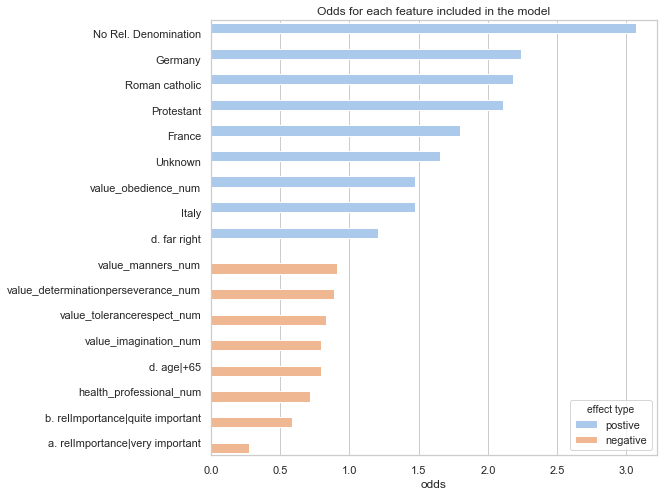

In [403]:
#odd plot
df_odds = pd.DataFrame(np.exp(result.params)).reset_index().rename(columns={"index": "feature", 0: "odds"}).sort_values('odds',ascending=0)

df_odds['effect type'] = np.where(df_odds['odds'] < 1, 'negative', 'postive')

fig, axes = plt.subplots(figsize=(8, 8))

sns.set(style="whitegrid")
d = df_odds
ax = sns.barplot(y='feature', x='odds', hue = 'effect type', data=d , palette="pastel")
ax.set(title = 'Odds for each feature included in the model', xlabel='odds', ylabel='')
#fig.suptitle('Attitude towards Euthanasia by emphasized values II', fontsize=24)

In [404]:
#logistic regression prediction model
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [405]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.70


In [406]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[ 467  813]
 [ 290 2064]]


Text(0.5, 257.44, 'Predicted label')

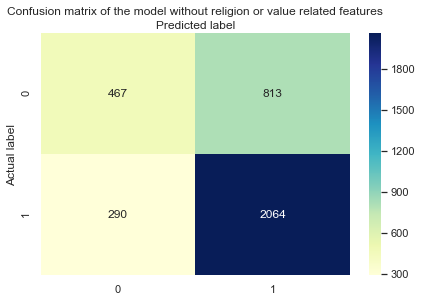

In [407]:
#confusiont matrix
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix of the model without religion or value related features', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [409]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.62      0.36      0.46      1280
         1.0       0.72      0.88      0.79      2354

    accuracy                           0.70      3634
   macro avg       0.67      0.62      0.62      3634
weighted avg       0.68      0.70      0.67      3634



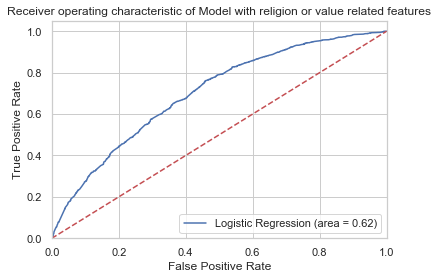

In [410]:
#ROC curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of Model with religion or value related features')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()